In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns 

import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import metrics 
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
import time

In [2]:
df = pd.read_csv("entreprenuer.csv")
df = df.drop(['EducationSector', 'ReasonsForLack'], axis = 1)

In [3]:
df.head(15)

,IndividualProject,Age,Gender,City,Influenced,Perseverance,DesireToTakeInitiative,Competitiveness,SelfReliance,StrongNeedToAchieve,SelfConfidence,GoodPhysicalHealth,MentalDisorder,KeyTraits,y
0,No,19,Male,Yes,No,2,2,3,3,2,2,3,Yes,Passion,1
1,Yes,22,Male,No,Yes,3,3,3,4,4,3,4,Yes,Vision,0
2,No,18,Male,Yes,No,3,4,3,3,3,4,4,No,Passion,0
3,Yes,20,Male,Yes,Yes,3,3,3,3,4,3,3,No,Resilience,0
4,Yes,19,Male,Yes,Yes,2,3,3,3,4,3,2,Yes,Vision,1
5,No,19,Male,Yes,Yes,3,3,3,3,3,3,3,No,Positivity,1
6,Yes,19,Male,Yes,Yes,3,2,3,3,4,1,1,No,Work Ethic,1
7,No,20,Male,Yes,Yes,4,2,4,4,5,3,4,Yes,Work Ethic,0
8,Yes,20,Male,Yes,Yes,2,3,3,1,2,2,2,No,Passion,0
9,Yes,17,Male,Yes,Yes,2,3,2,1,4,3,3,Yes,Work Ethic,1


In [4]:
df.isna().any()

IndividualProject         False
Age                       False
Gender                    False
City                      False
Influenced                False
Perseverance              False
DesireToTakeInitiative    False
Competitiveness           False
SelfReliance              False
StrongNeedToAchieve       False
SelfConfidence            False
GoodPhysicalHealth        False
MentalDisorder            False
KeyTraits                 False
y                         False
dtype: bool

In [5]:
df['y'].value_counts()

0    128
1     91
Name: y, dtype: int64

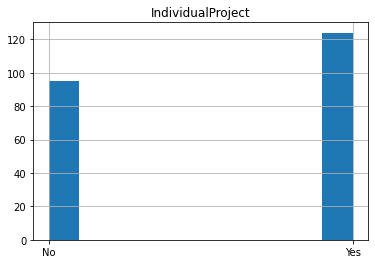

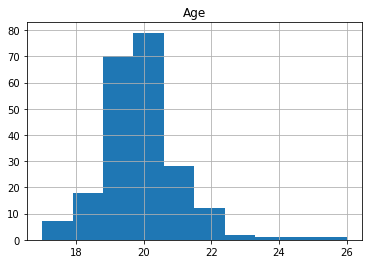

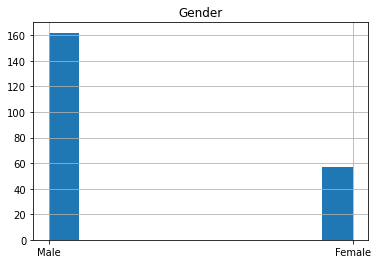

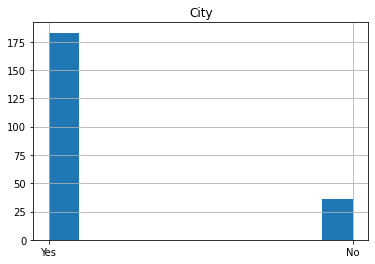

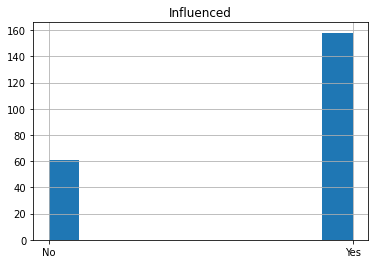

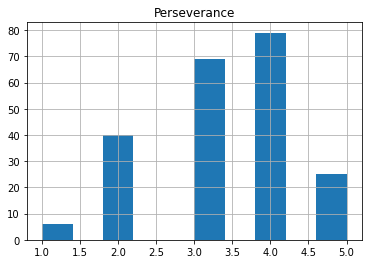

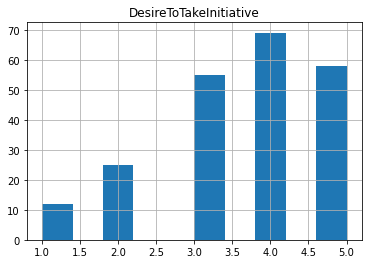

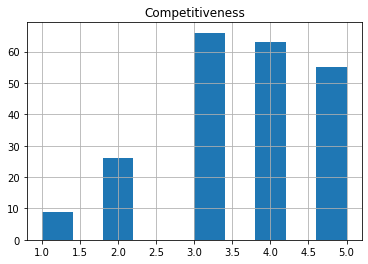

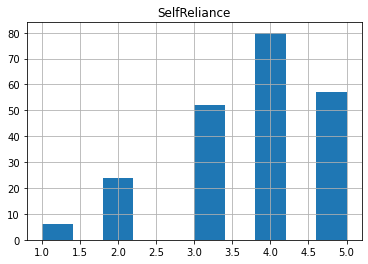

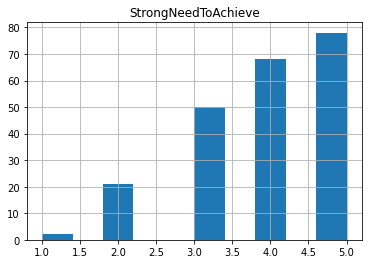

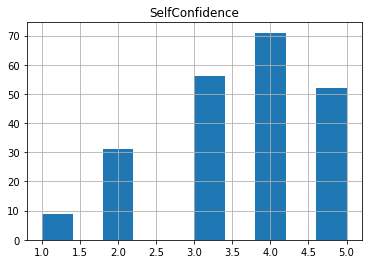

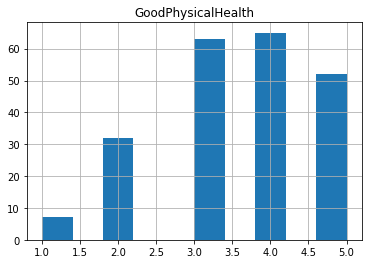

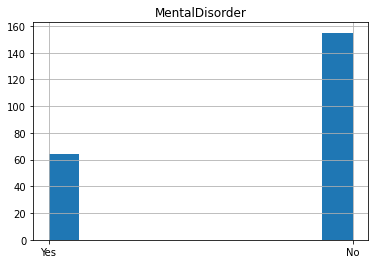

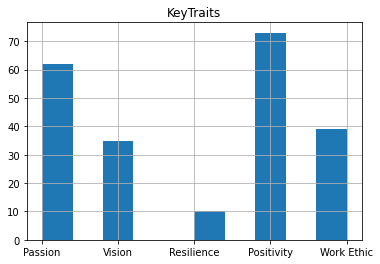

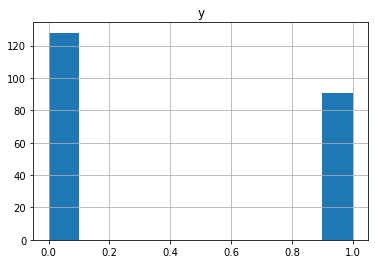

In [6]:
for variable in df.columns:
    df[variable].hist()
    plt.title(variable)
    plt.show()

<AxesSubplot:>

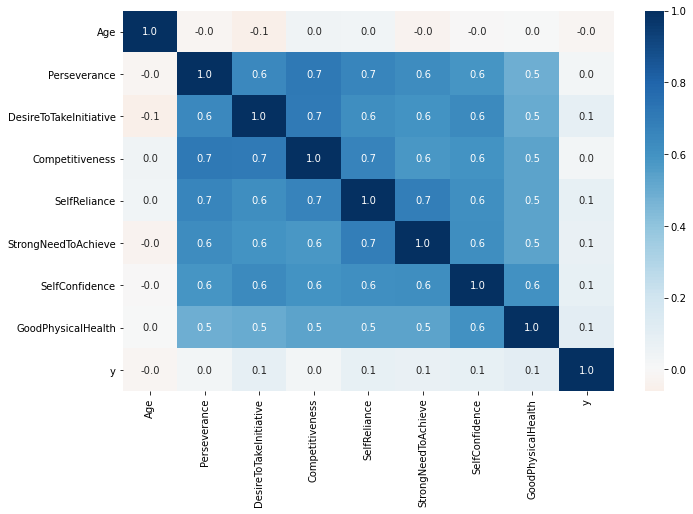

In [7]:
corr = df.corr()
fig, ax = plt.subplots()
fig.set_size_inches(11,7)
sns.heatmap(corr, annot = True, fmt = ".1f", cmap = 'RdBu', center = 0, ax = ax)

In [8]:
le = preprocessing.LabelEncoder()
en_df = df.apply(le.fit_transform)

In [9]:
x = en_df.drop(['y'], axis = 1)
y = en_df['y']

In [10]:
oversample = SMOTE()
x, y = oversample.fit_resample(x, y)

In [11]:
X_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.3, random_state = 42)

In [12]:
parameters = {
        'max_depth': range(2, 6),
        'n_estimators': [50, 100, 150, 200, 250, 300],
        'subsample': [0.6, 0.7, 0.8],
        'colsample_bytree': [0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 1],
        'colsample_bynode': [0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 1],
        'gamma': [0, 5, 10, 15, 20],
        'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
        'lambda': [0.1, 0.25, 0.5, 0.75, 1]
}

start = time.time() 

clf = RandomizedSearchCV(xgb.XGBClassifier(use_label_encoder = False, eval_metric = "logloss"), 
                         parameters, n_jobs=4, scoring = "roc_auc", n_iter = 60,
                         random_state = 123)

clf.fit(X_train, y_train)

end = time.time()

# print the number of seconds it takes to run the hyperparameter search
print("Total time in seconds ==> ", end - start)

Total time in seconds ==>  42.23080897331238


In [13]:
imp = pd.DataFrame()

# add a column for the variable names
imp["var"] = X_train.columns

# add a column with the feature importances
imp["imp"] = clf.best_estimator_.feature_importances_

# sort the data frame by the feature importances in descending order - most important features at the top
imp = imp.sort_values("imp", ascending = False).reset_index(drop = True)

# print out the data frame
imp

,var,imp
0,Influenced,0.123212
1,Gender,0.090043
2,DesireToTakeInitiative,0.084683
3,MentalDisorder,0.075997
4,GoodPhysicalHealth,0.072503
5,Age,0.069829
6,Competitiveness,0.068126
7,SelfReliance,0.065817
8,KeyTraits,0.064919
9,SelfConfidence,0.063466


In [14]:
train_pred = clf.predict(X_train)
val_pred = clf.predict(x_valid)

In [15]:
print("Training recall: ", metrics.recall_score(y_train, train_pred))
print("Validation recall: ", metrics.recall_score(y_valid, val_pred))

print("\n")

print("Training precision: ", metrics.precision_score(y_train, train_pred))
print("Validation precision: ", metrics.precision_score(y_valid, val_pred))

print("\n")

print("Training accuracy: ", metrics.accuracy_score(y_train, train_pred))
print("Validation accuracy: ", metrics.accuracy_score(y_valid, val_pred))

print("\n")

y_train_prob = clf.predict_proba(X_train)
y_val_prob = clf.predict_proba(x_valid)

fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_prob[:,1], pos_label = 1)
print("Training AUC: ", metrics.auc(fpr, tpr))

fpr, tpr, thresholds = metrics.roc_curve(y_valid, y_val_prob[:,1], pos_label = 1)
print("Validation AUC: ", metrics.auc(fpr, tpr))

Training recall:  0.968421052631579
Validation recall:  0.7272727272727273


Training precision:  1.0
Validation precision:  0.5333333333333333


Training accuracy:  0.9832402234636871
Validation accuracy:  0.6103896103896104


Training AUC:  0.9994360902255639
Validation AUC:  0.6935261707988981
